In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        # self.initial_scale = tf.keras.layers.Lambda(
        #     lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.initial_scale = tf.keras.layers.Dense(layer_width)
        
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) + Z
        return self.out(Z)




In [3]:
# Aiyagari problem parameters (TensorFlow constants)
kappa = tf.constant(0.5, dtype=tf.float32)  # mean reversion rate
theta = tf.constant(0.0, dtype=tf.float32)  # mean reversion level
sigma = tf.constant(2.0, dtype=tf.float32)  # volatility

# Mean and standard deviation for (normally distributed) process starting value
alpha = tf.constant(0.0, dtype=tf.float32)
beta = tf.constant(1.0, dtype=tf.float32)

nSim_x_interior = tf.constant(1000, dtype=tf.int32)  # Number of interior samples

# Replace NumPy arrays with TensorFlow tensors
X_low = tf.constant([-8.0], dtype=tf.float32)  # wealth lower bound
X_high = tf.constant([8.0], dtype=tf.float32)  # wealth upper bound

# Neural network parameters
num_layers_FFNN = 4
num_layers_RNN = 0
nodes_per_layer =50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'  # Activation function remains a string

# Training parameters
sampling_stages =1000  # Number of resampling stages
steps_per_sample = 10  # SGD steps per resampling

dim_input = 1
dim_output = 1

# Define the model
model = DCGMNet(X_low, X_high,
                dim_input, dim_output,  # Convert TensorFlow constants to Python integers
                num_layers_FFNN, nodes_per_layer,
                activation_FFNN)

In [5]:
def simulateOU_GaussianStart(theta, kappa, sigma, nSim):
    ''' Simulate end point of Ornstein-Uhlenbeck process with normally 
        distributed random starting value.
    
    Args:
        alpha: mean of random starting value
        beta:  standard deviation of random starting value
        theta: mean reversion level
        kappa: mean reversion rate
        sigma: volatility 
        nSim:  number of simulations
        T:     terminal time        
    '''  
        
    # simulate initial point based on normal distribution
    
    # mean and variance of OU endpoint
    m = theta 
    v = np.sqrt(sigma**2 / ( 2 * kappa) )
    
    # simulate endpoint
    X = np.random.normal(m,v,size=(nSim,1))    
    
    return X



def sampler(nSim_x_interior):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_x_interior: number of space points in the interior of the function's domain to sample 
    ''' 
    
    # Use TensorFlow's random uniform sampling
    x_interior = tf.random.uniform(
        shape=[nSim_x_interior, 1],
        minval=X_low[0],
        maxval=X_high[0],
        dtype=tf.float32
    )
    
    return x_interior


def compute_loss(model, x_interior):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_interior)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_interior)
            u = model(x_interior)
        u_x = tape1.gradient(u, x_interior)
        u_xx = tape2.gradient(u_x, x_interior)
        del tape1, tape2

    diff_f = kappa - kappa*(x_interior - theta)*u_x + 0.5*sigma**2 * (-u_xx + tf.square(u_x))
    return tf.reduce_mean(tf.square(diff_f))


In [6]:

def get_grad(model, x_interior):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x_interior)
    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad


In [7]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=starting_learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)

@tf.function
def train_step(model, x_interior):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, x_interior)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):
    # Sample uniformly from the required regions
    x_interior = sampler(nSim_x_interior)

    for _ in range(steps_per_sample):
        loss = train_step(model, x_interior)

    # Append the loss tensor directly
    hist.append(loss)

    if i % 100 == 0:
        tf.print(i, loss)
    

c:\Users\super\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['dcgm_net_1/dense_11/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


0 0.288731068
100 0.000150783
200 3.68470028e-05
300 3.07284354e-05
400 2.2609107e-05
500 5.41122427e-05
600 1.47741757e-05
700 1.36360832e-05
800 0.000308657967
900 1.08934328e-05


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35'),
  Text(0, 0.4, '0.40'),
  Text(0, 0.45, '0.45')])

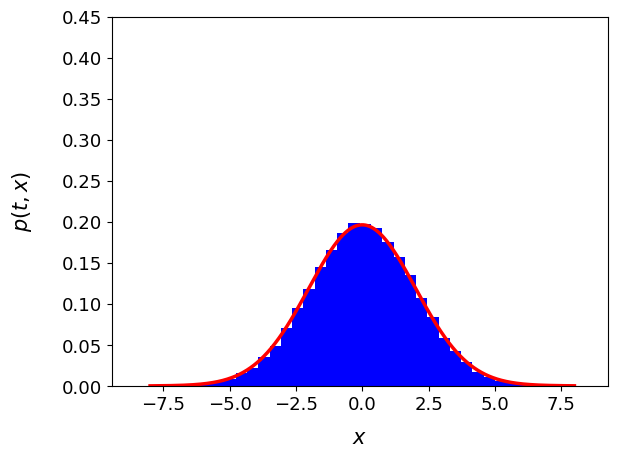

In [8]:


# vector of x values for plotting
x_plot = np.linspace(X_low, X_high, 1000)



# simulate process at current t
sim_x = simulateOU_GaussianStart(
    theta, kappa, sigma,nSim_x_interior*100)


x_plot = tf.cast(tf.reshape(x_plot, shape=[
    1000, 1]), tf.float32)

u = model(tf.stack([x_plot[:, 0]], axis=1))
u = u.numpy().reshape(-1,1)

p = np.exp(-u)
# p = u
x_plot_orig = np.linspace(X_low[0], X_high[0], 1000)
# print()

density = p/np.trapz(p.reshape(x_plot_orig.shape), x_plot_orig)
# density = p


# plot histogram of simulated process values and overlay estimated density
plt.hist(sim_x, bins=40, density=True, color='b')
plt.plot(x_plot, density, 'r', linewidth=2.5)

# subplot options
plt.ylim(ymin=0.0, ymax=0.45)
plt.xlabel(r"$x$", fontsize=15, labelpad=10)
plt.ylabel(r"$p(t,x)$", fontsize=15, labelpad=20)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

